## Session 10 - Image search with VGG16 and K-Nearest Neighbours

In [ ]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import notebook

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import (load_img, 
                                                  img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, 
                                                 preprocess_input)
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Helper functions

Q: What kind of preprocessing am I doing here? Why do you think I'm doing it?

In [4]:
# Extract features from image data using pretrained model (e.g. VGG16)
def extract_features(img_path, model):

    # Define input image shape - remember we need to reshape
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size = (input_shape[0], input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img, verbose = False)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features)
    
    return flattened_features

# Image search

## Load VGG16

In [5]:
model = VGG16(weights = 'imagenet',  # 'imagenet' = default weights
              include_top = False,          
              pooling = 'avg',
              input_shape = (224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Extract features from single image

In [10]:
target_image = os.path.join("..", "..", "..", "cds-vis-data", "data", "img", "florence.jpg")
features = extract_features(target_image, model)

In [ ]:
features

## Iterate over folder

In [12]:
# path to the datasets
root_dir = os.path.join("..", "..", "..", "cds-vis-data", "flowers")
filenames = [root_dir + "/" + name for name in sorted(os.listdir(root_dir))]

__Extract features for each image__

In [15]:
# initialize empty list for features
feature_list = []

# iterate over all files with a progress bar
for i in notebook.tqdm(range(len(filenames))):                 # tqdm returns a progress bar
    feature_list.append(extract_features(filenames[i], model))

  0%|          | 0/1360 [00:00<?, ?it/s]

## Nearest neighbours

Once we have our *database* of extracted embeddings, we can then use K-Nearest Neighbours to find similar images.

In [17]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors = 10,      # "return the 10 most similar neighbors"
                             algorithm = 'brute',   # compares all images in the dataset to find the 10 nearest neighbors
                             metric = 'cosine').fit(feature_list)

__Calculate nearest neighbours for target__

In [18]:
distances, indices = neighbors.kneighbors([feature_list[250]])

__Save indices, print data__

In [19]:
idxs = []
for i in range(1,6): 
    print(distances[0][i], indices[0][i]) # print the 5 most similar images with distance score and image index
    idxs.append(indices[0][i])

0.14842796 248
0.21073085 249
0.21198976 245
0.22384572 244
0.22834104 240


__Plot target image__

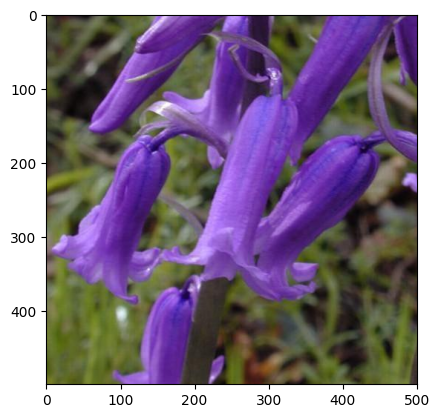

In [26]:
plt.imshow(mpimg.imread(filenames[250]))

__Plot close images__

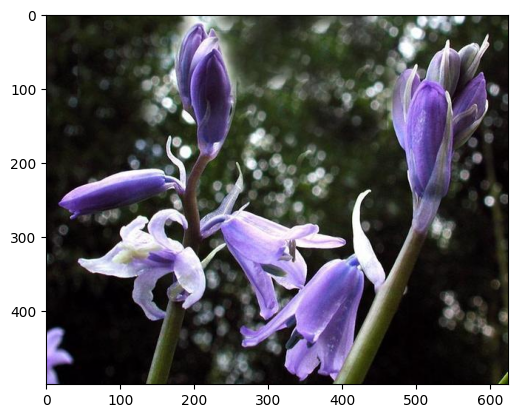

In [28]:
plt.imshow(mpimg.imread(filenames[249]))

__Plot target and top 3 closest together__

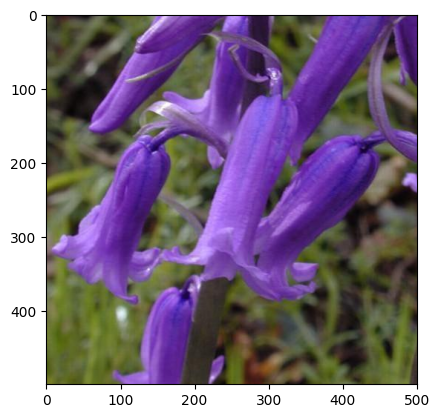

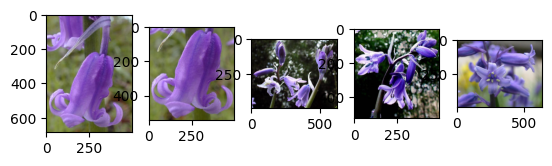

In [32]:
# plt target
plt.imshow(mpimg.imread(filenames[250]))

# plot 3 most similar
f, axarr = plt.subplots(1,5)
axarr[0].imshow(mpimg.imread(filenames[idxs[0]]))
axarr[1].imshow(mpimg.imread(filenames[idxs[1]]))
axarr[2].imshow(mpimg.imread(filenames[idxs[2]]))
axarr[3].imshow(mpimg.imread(filenames[idxs[3]]))
axarr[4].imshow(mpimg.imread(filenames[idxs[4]]))

## Simple style transfer

__Load a quick style transfer model from TF Hub__

You can find more details [here](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization).

You can also play around with an interactive version with the same model at [this website](https://reiinakano.com/arbitrary-image-stylization-tfjs/).

In [33]:
from utils.styletransfer import st_load, show_n

# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

__Load the content image and the style image__

In [40]:
content_image = st_load(os.path.join("..", "..", "..", "cds-vis-data", "data", "img", "trex.png"))
style_image = st_load(os.path.join("..", "..", "..", "cds-vis-data", "data", "img", "the_bedroom.jpg"))

__Process using the model__

In [41]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

__Show content, style, and stylized image__

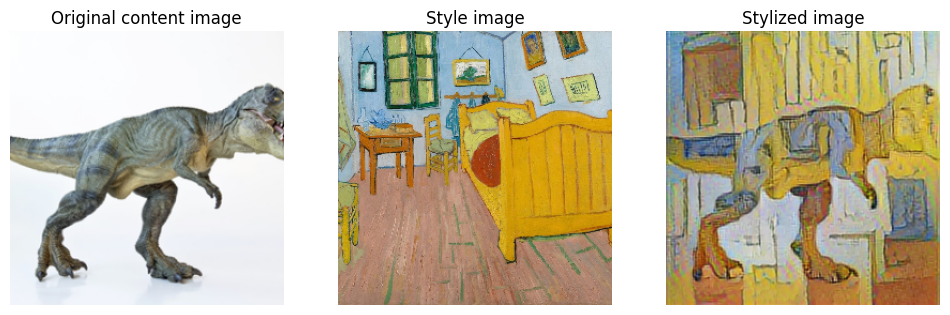

In [42]:
show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])

### Tasks

- Take the code in this notebook and turn it into a Python script. You can then add this to the repo for your Assignment 1 solution for creating doing image search
  - I.e. your Assignment 1 repo would contain both code for image search using colour histograms *and* for image search using a pretrained CNN.